In [1]:
# Dependencies
import tweepy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import json
import yaml

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def pretty_print_json(json_obj):
    print(json.dumps(json_obj, sort_keys=True, indent=4, separators=(',', ': ')))

In [2]:
TWITTER_CONFIG_FILE = 'auth.yaml'

with open(TWITTER_CONFIG_FILE, 'r') as config_file:
    config = yaml.load(config_file)
    
consumer_key = config['twitter']['consumer_key']
consumer_secret = config['twitter']['consumer_secret']
access_token = config['twitter']['access_token']
access_token_secret = config['twitter']['access_token_secret']

In [3]:
# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [4]:
# Target Search Term
# BBC, CBS, CNN, Fox, and New York times
target_terms = ("@BBC", "@CBS", "@CNN", "@FoxNews", "@nytimes")

# Array to hold sentiment
sentiments = []

In [5]:
# for debugging
# public_tweets = api.user_timeline("@BBC")
# pretty_print_json(public_tweets)

In [6]:
# Loop through all media sources
for target_user in target_terms:
    counter = 1
    # Loop through 5 pages of tweets (total 100 tweets)
    for x in range(5):
        # Get all tweets from home feed
        public_tweets = api.user_timeline(target_user, page=x)
        # Loop through all tweets 
        for tweet in public_tweets:
            # Run Vader Analysis on each tweet
            compound = analyzer.polarity_scores(tweet["text"])["compound"]
            pos = analyzer.polarity_scores(tweet["text"])["pos"]
            neu = analyzer.polarity_scores(tweet["text"])["neu"]
            neg = analyzer.polarity_scores(tweet["text"])["neg"]
            tweet_text = tweet["text"]

            # Add sentiments for each tweet into an array
            sentiments.append({ "Tweets Ago": counter,
                                     "Media": tweet["user"]["screen_name"],
                                      "Date": tweet["created_at"], 
                                     "Tweet": tweet_text,
                                  "Compound": compound,
                                  "Positive": pos,
                                  "Negative": neu,
                                   "Neutral": neg })

            # Add to counter 
            counter = counter + 1

In [7]:
# Convert sentiments to DataFrame
sentiments_pd = pd.DataFrame.from_dict(sentiments)
sentiments_pd = sentiments_pd[["Tweets Ago","Media","Tweet","Date","Compound","Positive","Negative","Neutral"]]
sentiments_pd.head()

,Tweets Ago,Media,Tweet,Date,Compound,Positive,Negative,Neutral
0,1,BBC,Switzerland's Schindler? \nCarl Lutz is the fo...,Sun Jan 07 20:03:03 +0000 2018,0.2263,0.158,0.734,0.107
1,2,BBC,"Tonight, Michael Palin shares the story behind...",Sun Jan 07 19:30:04 +0000 2018,0.7351,0.279,0.721,0.000
2,3,BBC,RT @BBCWorld: Snowing or glowing? https://t.co...,Sun Jan 07 19:25:10 +0000 2018,0.0000,0.000,1.000,0.000
3,4,BBC,RT @BBCRadio4: 🎪 Roll up! Roll up!\nhttps://t....,Sun Jan 07 19:22:48 +0000 2018,0.0000,0.000,1.000,0.000
4,5,BBC,RT @bbccomedy: We can't keep up with the Karcr...,Sun Jan 07 19:19:39 +0000 2018,0.0000,0.000,1.000,0.000


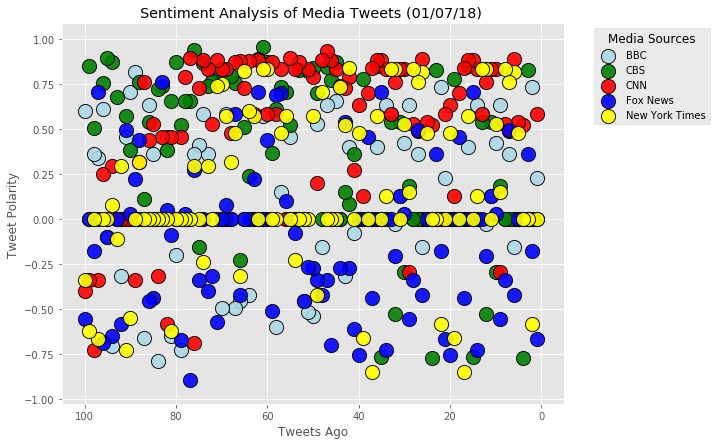

In [8]:
# Plot1 - Scatter Plot
# Create plot
plt.style.use('ggplot')
fig = plt.figure(figsize=(9,7))
colors = ['lightblue', 'green', 'red', 'blue','yellow']
# Split data
bbc_df = sentiments_pd[sentiments_pd["Media"] == "BBC"]
cbs_df = sentiments_pd[sentiments_pd["Media"] == "CBS"]
cnn_df = sentiments_pd[sentiments_pd["Media"] == "CNN"]
fox_df = sentiments_pd[sentiments_pd["Media"] == "FoxNews"]
nyt_df = sentiments_pd[sentiments_pd["Media"] == "nytimes"]

# Plot Graph
bbc = plt.scatter(bbc_df["Tweets Ago"],bbc_df["Compound"],s=200, c=colors[0], alpha=0.9, linewidths=1, edgecolor='black')
cbs = plt.scatter(cbs_df["Tweets Ago"],cbs_df["Compound"],s=200, c=colors[1], alpha=0.9, linewidths=1, edgecolor='black')
cnn = plt.scatter(cnn_df["Tweets Ago"],cnn_df["Compound"],s=200, c=colors[2], alpha=0.9, linewidths=1, edgecolor='black')
fox = plt.scatter(fox_df["Tweets Ago"],fox_df["Compound"],s=200, c=colors[3], alpha=0.9, linewidths=1, edgecolor='black')
nyt = plt.scatter(nyt_df["Tweets Ago"],nyt_df["Compound"],s=200, c=colors[4], alpha=0.9, linewidths=1, edgecolor='black')

# # Incorporate the other graph properties
legend = plt.legend((bbc,cbs,cnn,fox,nyt),("BBC","CBS","CNN","Fox News","New York Times"),fontsize="10", mode="Expanded",
           bbox_to_anchor=(1.3,1), loc="upper right", title="Media Sources", labelspacing=0.5, numpoints=1, scatterpoints=1)
legend.get_title().set_fontsize('12') 
plt.xlim(105,-5)
# plt.ylim(-1,1)

plt.title("Sentiment Analysis of Media Tweets (%s) " % (time.strftime("%x")))
plt.ylabel("Tweet Polarity")
plt.xlabel("Tweets Ago")
# Save the figure
plt.savefig("Media_Tweet_Sentiments.png")
# show
plt.show()

In [9]:
# Export the data into a CSV file
sentiments_pd.to_csv("Media_Tweet_Sentiments.csv",encoding='utf-8')

In [10]:
# Group data by media
sentments_group = sentiments_pd.groupby("Media")["Compound"].mean()
sentments_group.head()

Media
BBC        0.102894
CBS        0.332653
CNN        0.485517
FoxNews   -0.090801
nytimes    0.160335
Name: Compound, dtype: float64

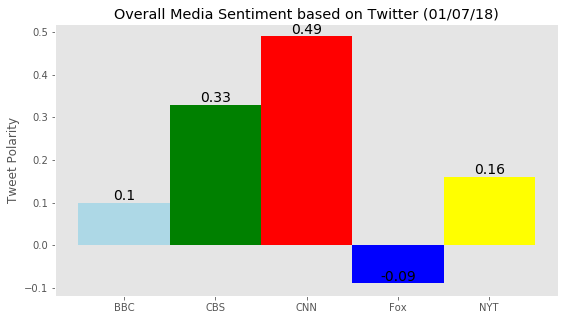

In [11]:
# Set values for X, Y axis and bar width
# x = sentments_group.index
x = ["BBC","CBS","CNN","Fox","NYT"]
y = sentments_group.round(2)
bar_width = 1

# Plot Bar Chart 
fig = plt.figure(figsize=(9,5))
bars = plt.bar(x, y, bar_width, color=colors, lw=1)

# Set Graph Properties
plt.ylabel('Tweet Polarity')
plt.title('Overall Media Sentiment based on Twitter (%s)' % (time.strftime("%x"))) 
plt.grid(False)

# Set the bar value inside each bar
for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                '%s' % (str(float(height))),
                ha='center', va='bottom', color="black", fontsize="14")
# Save the figure
plt.savefig("Summary_BarGraph.png")

# Show graph
plt.show()